In [ ]:
# Load in relevant libraries, and alias where appropriate
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import pandas as pd
import os

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
data_path = '/content/drive/MyDrive/Traffic_Signs_Detection'
os.chdir(data_path)

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Creating Dataloaders

In [ ]:
#Defining Transforms
img_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
#Defining class for dataset
class GTSRBDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.meta_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):

      # get image path and bounding box coordinates
      img_path = os.path.join(self.root_dir, self.meta_data.iloc[idx, 7])
      image = Image.open(img_path).convert('RGB')

      x1 = self.meta_data.iloc[idx, 2]
      y1 = self.meta_data.iloc[idx, 3]
      x2 = self.meta_data.iloc[idx, 4]
      y2 = self.meta_data.iloc[idx, 5]

      # crop image based on roi bounding box
      image = image.crop((x1, y1, x2, y2))

      # Label
      label = int(self.meta_data.iloc[idx, 6])

      if self.transform:
          image = self.transform(image)

      return image, label

In [ ]:
train_dataset = GTSRBDataset(csv_file='/content/drive/MyDrive/Traffic_Signs_Detection/Train.csv', root_dir=data_path, transform=img_transforms)

test_dataset = GTSRBDataset(csv_file='/content/drive/MyDrive/Traffic_Signs_Detection/Test.csv', root_dir=data_path, transform=img_transforms)

In [ ]:
# create validation set from training set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

len(train_dataset), len(val_dataset), len(test_dataset)

(31367, 7842, 12630)

In [ ]:
#train loader
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True)

#validation loader
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

#test loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

### Exploratory Data Analysis (EDA)

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

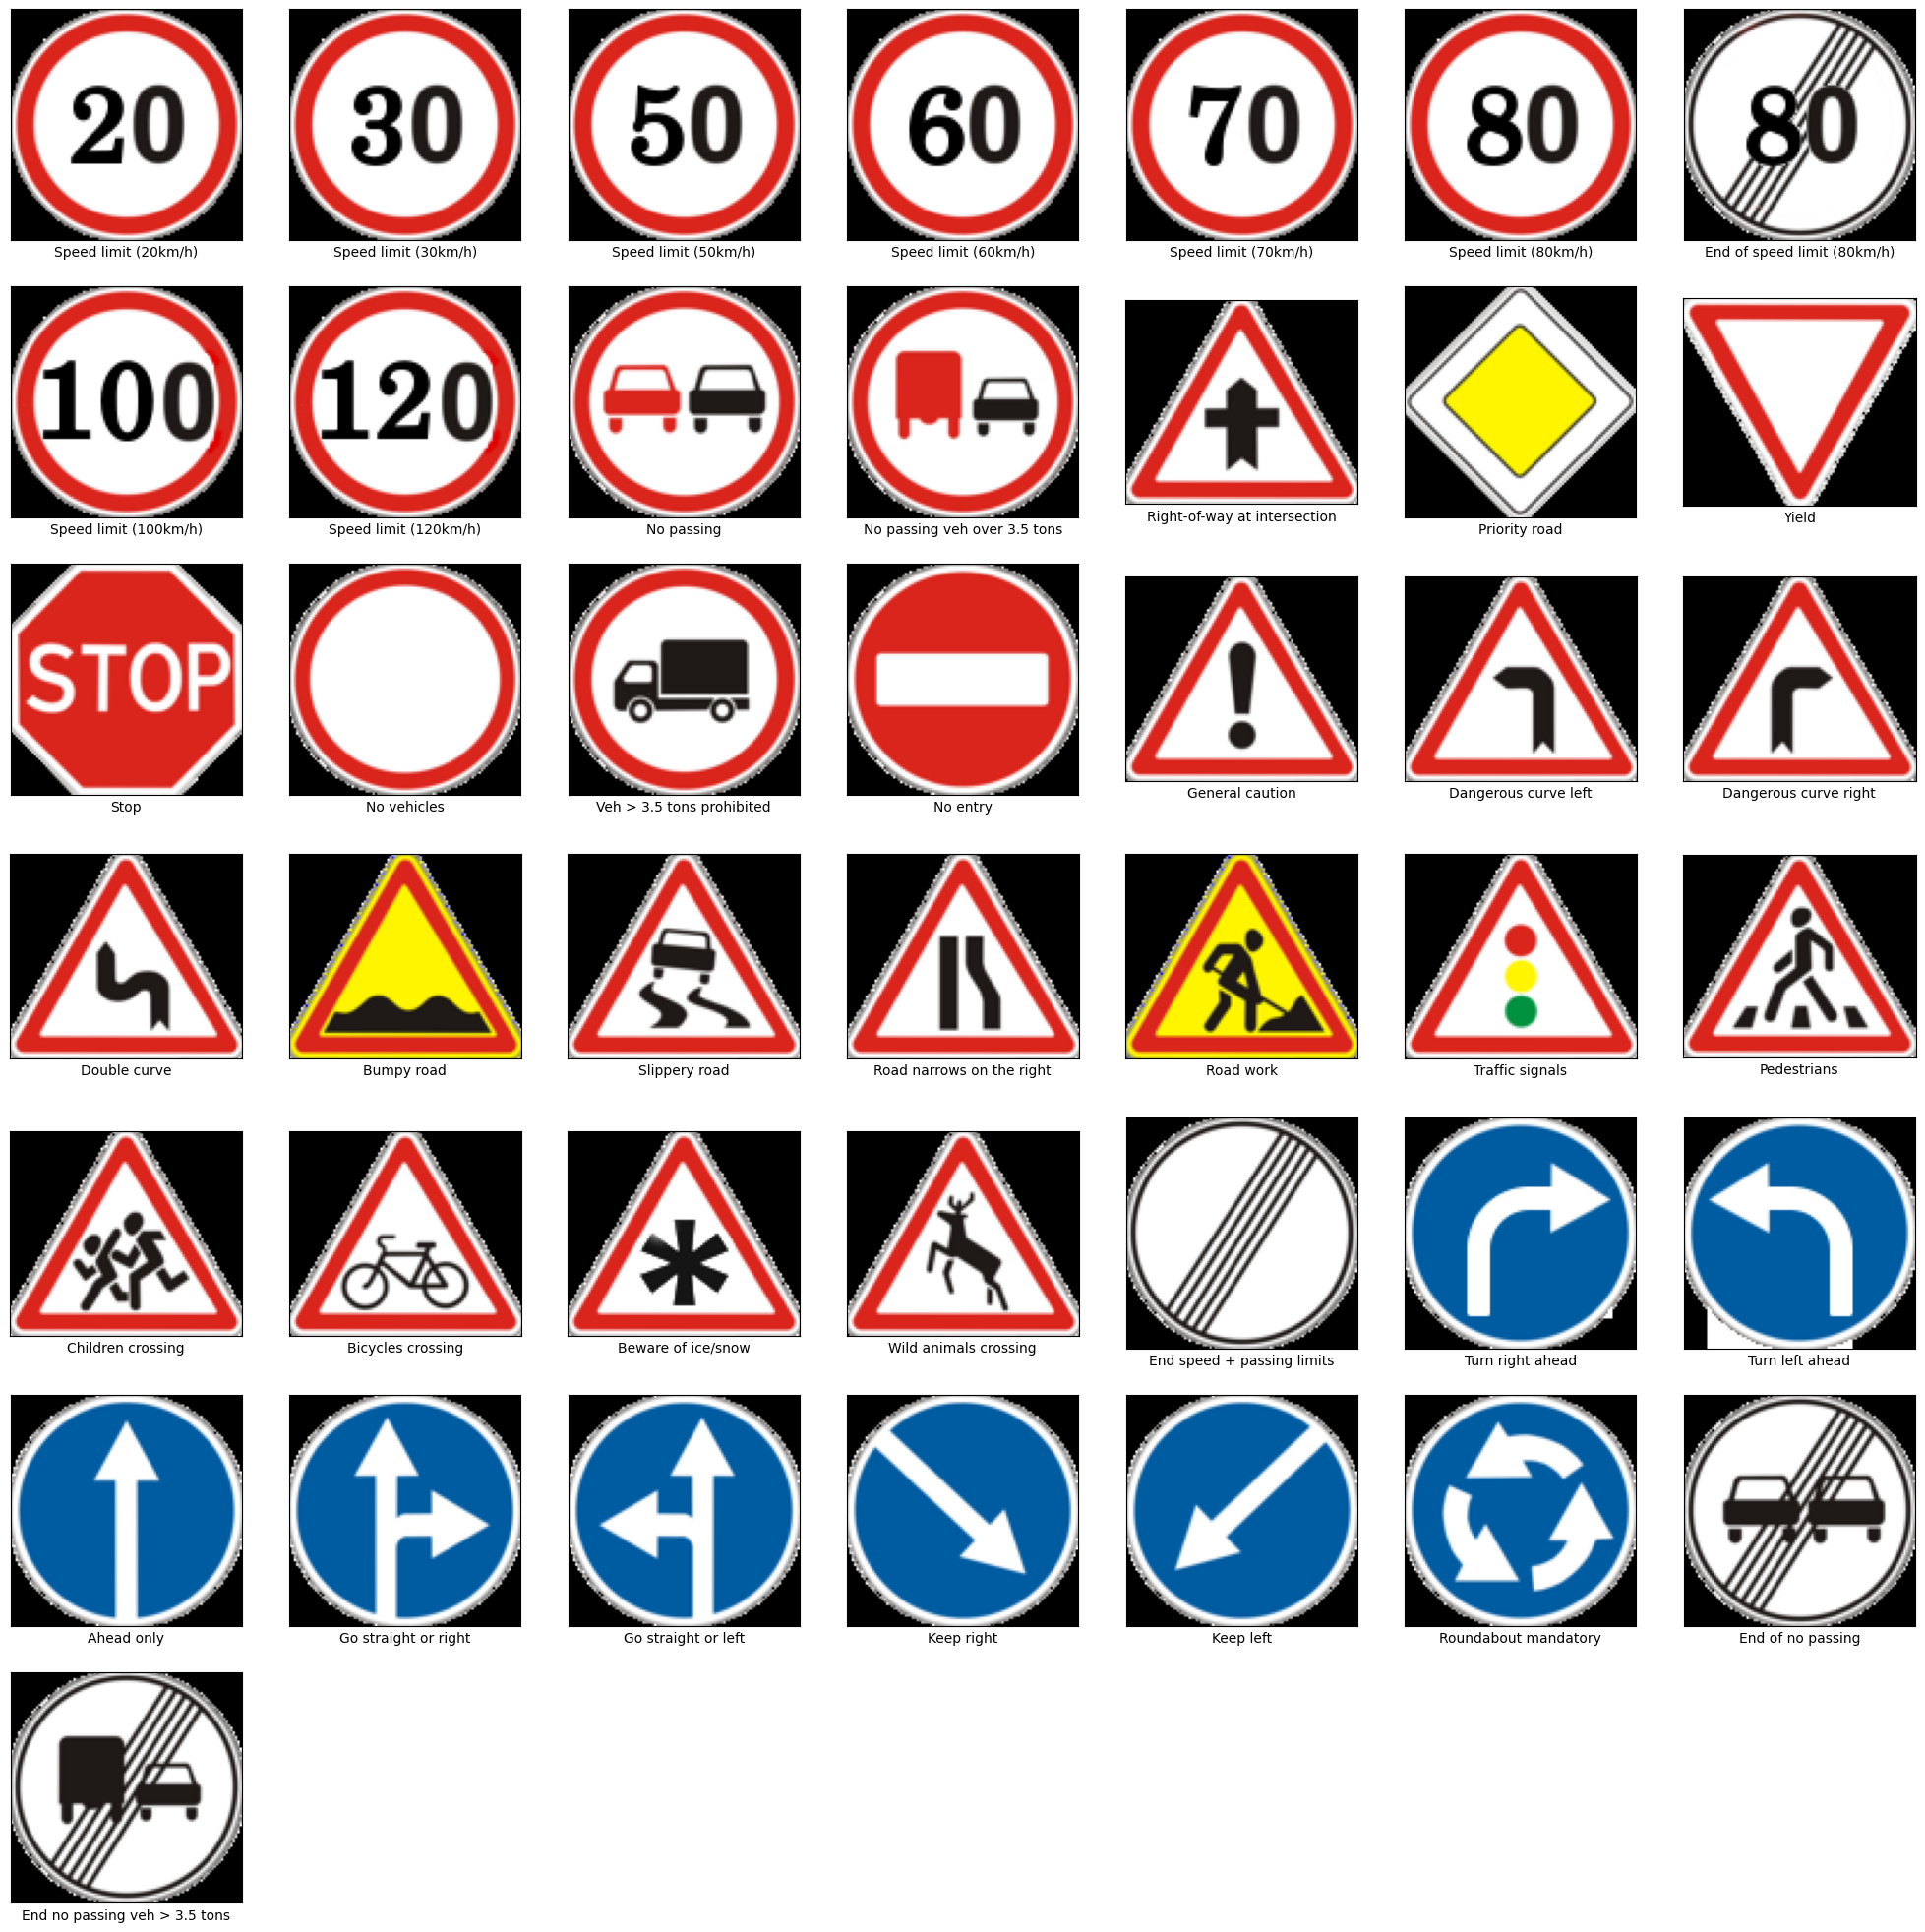

In [ ]:
import cv2
import glob
sortFunction = lambda x: int(os.path.basename(x)[:-4])
plt.figure(figsize = (25, 25))
for i, imagename in enumerate(sorted(glob.glob(data_path + '/Meta/' + '*.*'), key = sortFunction)):
    plt.subplot(7, 7, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes[i])
    image = cv2.imread(imagename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
df_meta = pd.read_csv(data_path + '/Meta.csv')
df_train = pd.read_csv(data_path + '/Train.csv')
df_test = pd.read_csv(data_path + '/Test.csv')

In [ ]:
df_train.ClassId.value_counts()

,count
ClassId,
2,2250
1,2220
13,2160
12,2100
38,2070
10,2010
4,1980
5,1860
25,1500


In [ ]:
train_dict = {}
train_dict = {keys:values for keys,values in zip(df_train.ClassId.value_counts().index, df_train.ClassId.value_counts().tolist())}

Text(0.5, 1.0, 'Class Distribution for Training data')

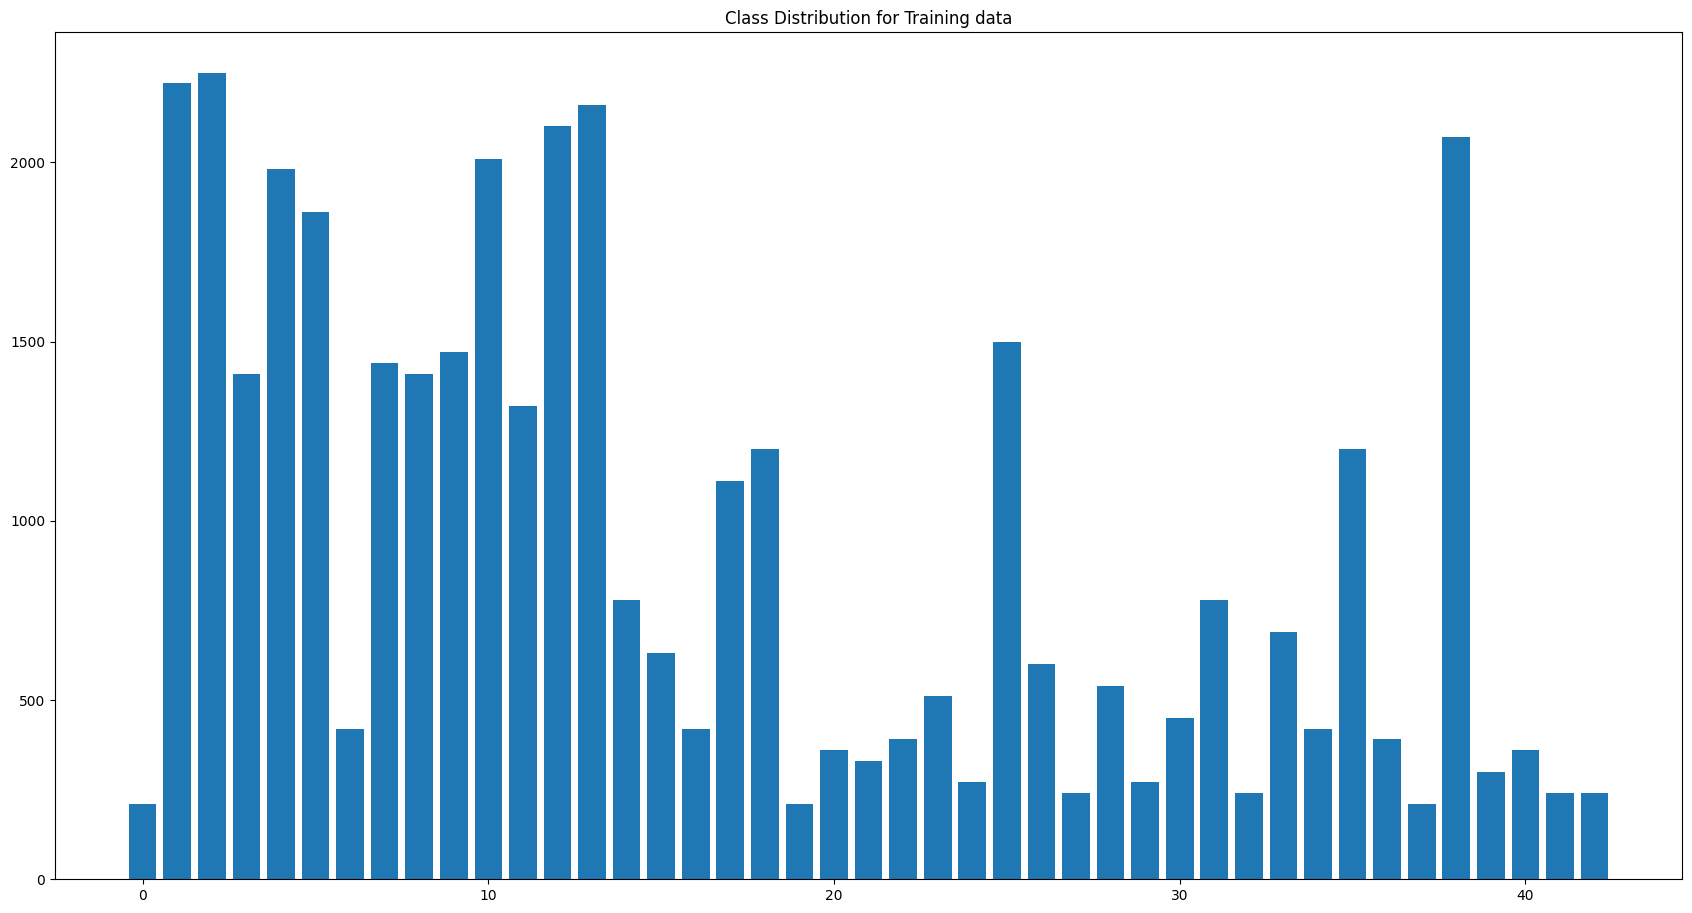

In [ ]:
plt.figure(figsize = (21 ,11))
plt.bar(train_dict.keys(), train_dict.values())
plt.title('Class Distribution for Training data')

In [ ]:
df_test.ClassId.value_counts()

,count
ClassId,
2,750
1,720
13,720
38,690
12,690
4,660
10,660
5,630
9,480


In [ ]:
# Create a test_dict with keys as the labels and values as the value_counts
test_dict = {}
test_dict = {keys:values for keys,values in zip(df_test.ClassId.value_counts().index, df_test.ClassId.value_counts().tolist())}

Text(0.5, 1.0, 'Class Distribution of Test Data')

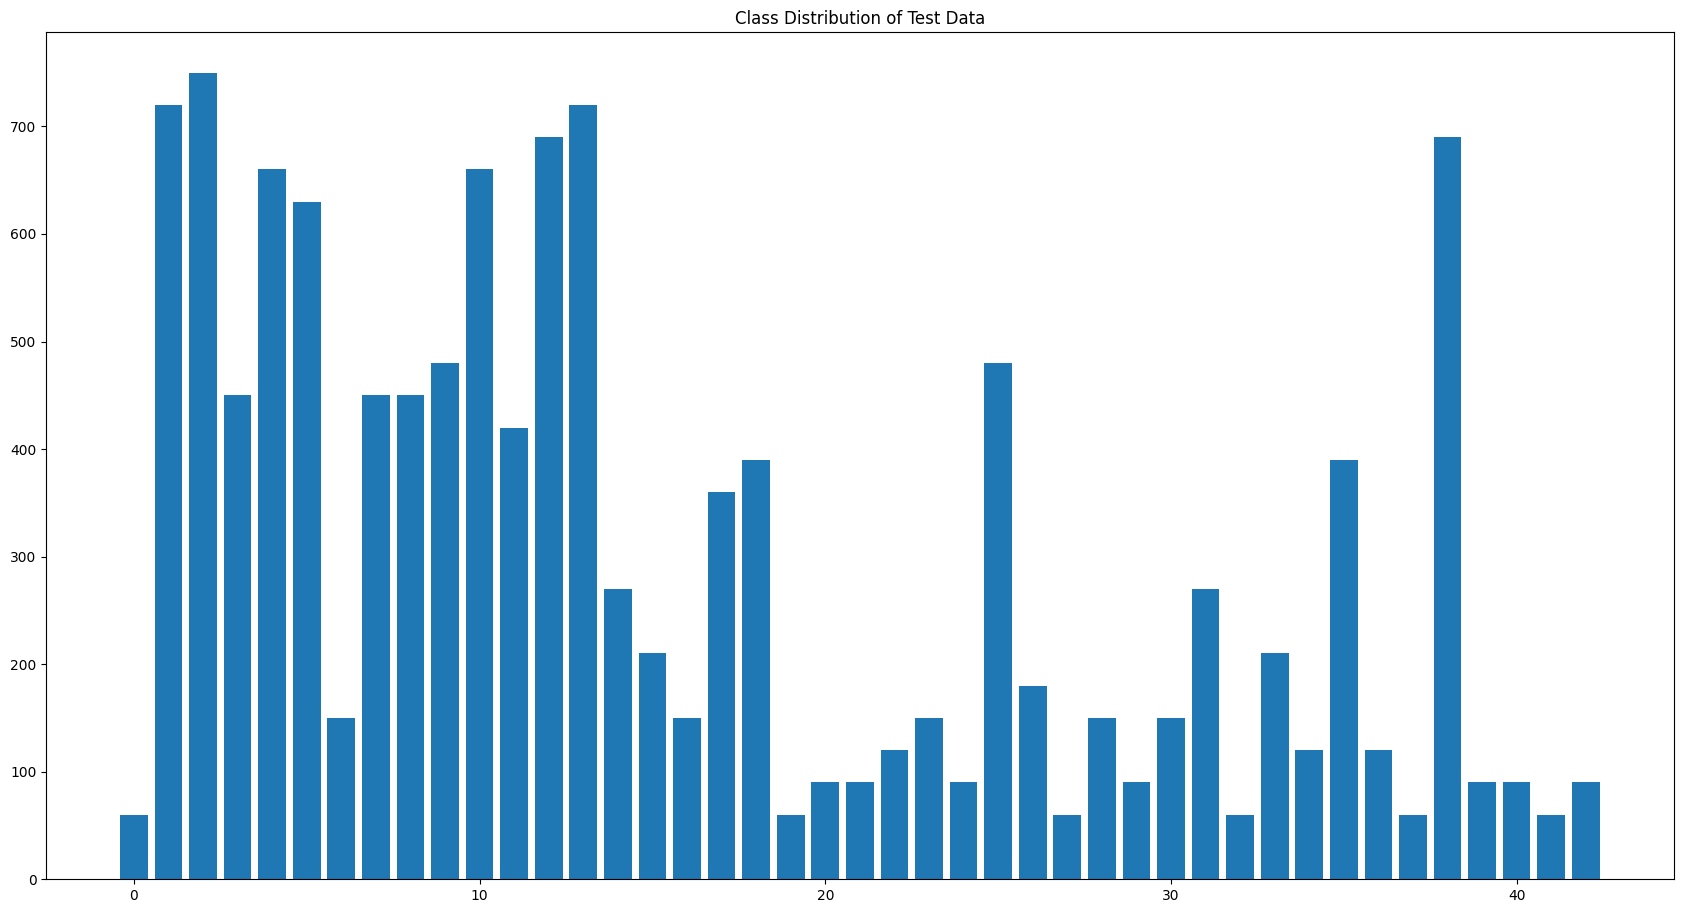

In [ ]:
plt.figure(figsize = (21, 11))
plt.bar(test_dict.keys(), test_dict.values())
plt.title("Class Distribution of Test Data")

In [ ]:
df_balance = pd.DataFrame()
df_balance['labels'] = list(range(43))
df_balance['train'] = train_dict.values()
df_balance['test'] = test_dict.values()
df_balance['total'] = df_balance['train'] + df_balance['test']
df_balance['train_ratio'] = df_balance['train']/df_balance['total']
df_balance['test_ratio'] = df_balance['test']/df_balance['total']

<Axes: title={'center': 'Train Test Ratio for each class'}, xlabel='labels'>

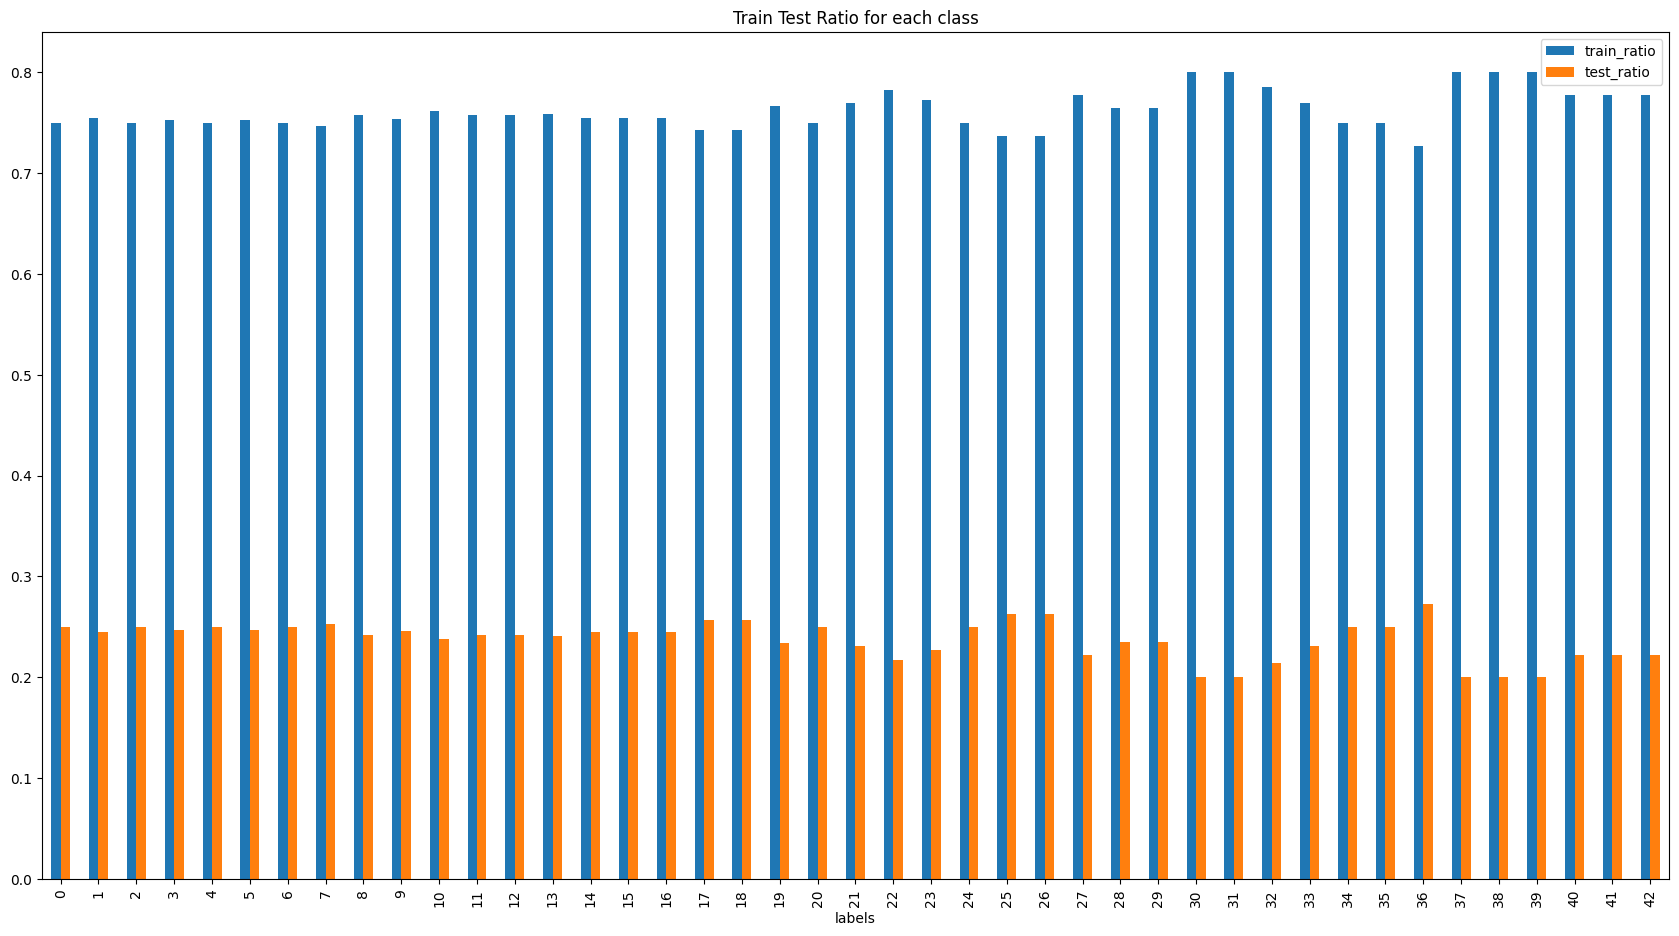

In [ ]:
df_balance.plot(x = 'labels', y = ['train_ratio', 'test_ratio'], kind = 'bar', figsize = (21, 11), title = "Train Test Ratio for each class")


In [ ]:
df_train.Path.duplicated().unique()

array([False])

In [ ]:
df_test.Path.duplicated().unique()

array([False])

### Model

In [ ]:
import torch
import torch.nn as nn

class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()

        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 43)
        )

    def forward(self, x):
        #x = x.view(x.size(0), -1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

# Create model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TrafficSignNet().to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(model)

TrafficSignNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Con

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,472
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]         204,928
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         409,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         295,168
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 44138923


In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| conv1.0.weight |    9408    |
|  conv1.0.bias  |     64     |
| conv1.1.weight |     64     |
|  conv1.1.bias  |     64     |
| conv2.0.weight |   204800   |
|  conv2.0.bias  |    128     |
| conv2.1.weight |    128     |
|  conv2.1.bias  |    128     |
| conv2.3.weight |   409600   |
|  conv2.3.bias  |    128     |
| conv2.4.weight |    128     |
|  conv2.4.bias  |    128     |
| conv3.0.weight |   294912   |
|  conv3.0.bias  |    256     |
| conv3.1.weight |    256     |
|  conv3.1.bias  |    256     |
| conv3.3.weight |  1179648   |
|  conv3.3.bias  |    512     |
| conv3.4.weight |    512     |
|  conv3.4.bias  |    512     |
|  fc.1.weight   |  33554432  |
|   fc.1.bias    |    4096    |
|  fc.4.weight   |  8388608   |
|   fc.4.bias    |    2048    |
|  fc.7.weight   |   88064    |
|   fc.7.bias    |     43     |
+----------------+------------+
Total Trainable Params: 44138923


44138923

## Train Test Loop

In [ ]:
import time
from datetime import datetime, timedelta

def fit(
    model,
    train_loader,
    val_loader=None,
    epochs=10,
    optimizer=None,
    criterion=None,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    patience=5
):
    # Default optimizer and criterion if not provided
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())
    if criterion is None:
        criterion = torch.nn.CrossEntropyLoss()

    # Move model to device
    model = model.to(device)

    # Initialize tracking variables
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'epoch_times': []}

    # Calculate total batches for progress tracking
    total_batches = len(train_loader)

    # Start total training timer
    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Forward pass
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate ETA
            if batch_idx % 10 == 0:  # Update every 10 batches
                elapsed_time = time.time() - epoch_start_time
                batches_done = batch_idx + 1
                batches_left = total_batches - batches_done
                time_per_batch = elapsed_time / batches_done
                eta = time_per_batch * batches_left

                print(f'\rBatch [{batch_idx + 1}/{total_batches}] - '
                      f'ETA: {timedelta(seconds=int(eta))}', end='')

        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0

            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += criterion(output, target).item()

            avg_val_loss = val_loss / len(val_loader)
            history['val_loss'].append(avg_val_loss)

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        history['epoch_times'].append(epoch_time)

        # Calculate total time elapsed and estimated time remaining
        total_time_elapsed = time.time() - total_start_time
        avg_epoch_time = total_time_elapsed / (epoch + 1)
        estimated_time_remaining = avg_epoch_time * (epochs - (epoch + 1))

        # Print epoch results
        print(f'\nEpoch {epoch + 1}/{epochs} - '
              f'Time: {timedelta(seconds=int(epoch_time))} - '
              f'loss: {avg_train_loss:.4f}', end='')

        if val_loader is not None:
            print(f' - val_loss: {avg_val_loss:.4f}', end='')

        print(f'\nEstimated time remaining: {timedelta(seconds=int(estimated_time_remaining))}')

        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch + 1}')
            break

    total_training_time = time.time() - total_start_time
    print(f'\nTotal training time: {timedelta(seconds=int(total_training_time))}')

    return history

In [ ]:
history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=25,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    criterion=torch.nn.CrossEntropyLoss(),
    patience=5
)

Batch [491/491] - ETA: 0:00:00
Epoch 1/25 - Time: 2:14:57 - loss: 2.6563 - val_loss: 1.6795
Estimated time remaining: 2 days, 5:58:51
Batch [491/491] - ETA: 0:00:00
Epoch 2/25 - Time: 0:03:39 - loss: 1.4176 - val_loss: 1.0508
Estimated time remaining: 1 day, 2:34:02
Batch [491/491] - ETA: 0:00:00
Epoch 3/25 - Time: 0:03:38 - loss: 0.8882 - val_loss: 0.4216
Estimated time remaining: 17:23:08
Batch [491/491] - ETA: 0:00:00
Epoch 4/25 - Time: 0:03:35 - loss: 0.5993 - val_loss: 0.3160
Estimated time remaining: 12:45:36
Batch [491/491] - ETA: 0:00:00
Epoch 5/25 - Time: 0:03:38 - loss: 0.4053 - val_loss: 0.1967
Estimated time remaining: 9:57:52
Batch [491/491] - ETA: 0:00:00
Epoch 6/25 - Time: 0:03:39 - loss: 0.2980 - val_loss: 0.1341
Estimated time remaining: 8:04:53
Batch [491/491] - ETA: 0:00:00
Epoch 7/25 - Time: 0:03:37 - loss: 0.2507 - val_loss: 0.0984
Estimated time remaining: 6:43:04
Batch [491/491] - ETA: 0:00:00
Epoch 8/25 - Time: 0:03:38 - loss: 0.1841 - val_loss: 0.0734
Estimated

In [ ]:
# Loss graph
plt.plot(history['train_loss'], label='training loss')
plt.plot(history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


## Evaluation

In [ ]:
def predict(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure model is on the same device as the data

    model.eval()
    test_labels = []
    predicted_labels = []

    with torch.no_grad():  # Use torch.no_grad() for inference to save memory
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            output = model(images)
            _, predicted = torch.max(output, 1)  # Get the index of the max log-probability

            test_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy array
            predicted_labels.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy array

    return test_labels, predicted_labels

In [ ]:
# test model
test_labels, predicted_labels = predict(model, test_loader)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, precision_score, recall_score

# print accuracy , f1score ,precision and recall
print("Accuracy:", accuracy_score(test_labels, predicted_labels))
print("F1 Score:", f1_score(test_labels, predicted_labels, average='weighted'))
print("Precision:", precision_score(test_labels, predicted_labels, average='weighted'))
print("Recall:", recall_score(test_labels, predicted_labels, average='weighted'))

In [ ]:
# print classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [ ]:
# visualize confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# plot real labels
plt.figure(figsize=(20, 15))  # Set figure size to 20x15
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(len(cm[0]))], yticklabels=[str(i) for i in range(len(cm))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Save Model

In [ ]:
torch.save(model.(), 'traffic_sign_detection.pth')